Number of reference keypoints detected:  500
Number of align image keypoints detected:  500


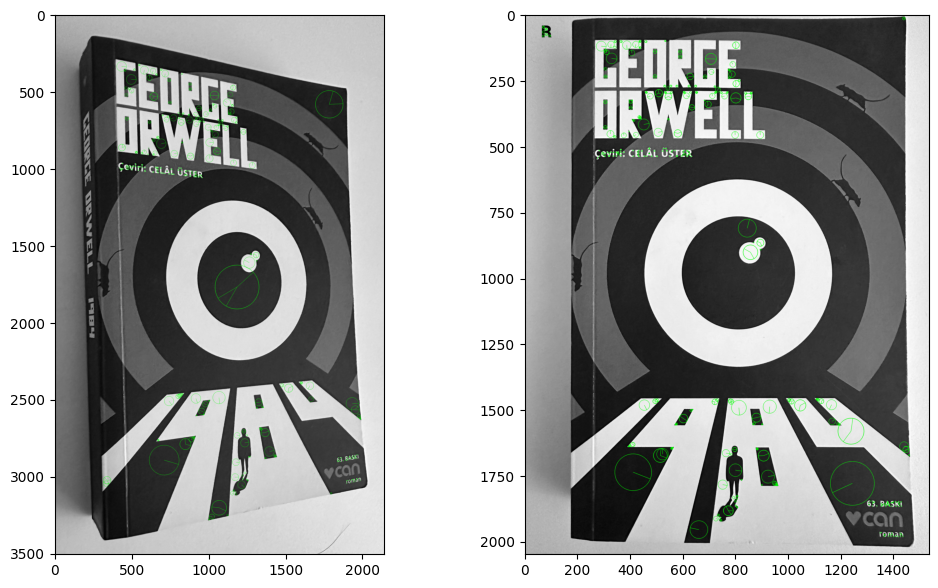

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imgAlign = cv2.imread('./images/george6.jpeg', cv2.IMREAD_GRAYSCALE)
imgReference = cv2.imread('./images/george1e.jpg', cv2.IMREAD_GRAYSCALE)

sift = cv2.SIFT_create(500)

h, w = imgAlign.shape

alignKp, des1 = sift.detectAndCompute(imgAlign, None)
referenceKp, des2 = sift.detectAndCompute(imgReference, None)

imgAlign = cv2.drawKeypoints(imgAlign, alignKp, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imgReference = cv2.drawKeypoints(imgReference, referenceKp, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

print("Number of reference keypoints detected: ", len(referenceKp))
print("Number of align image keypoints detected: ", len(alignKp))

plt.figure(figsize=(12, 7))
plt.subplot(121)
plt.imshow(imgAlign)
plt.subplot(122)
plt.imshow(imgReference)


Number of good matches:  50


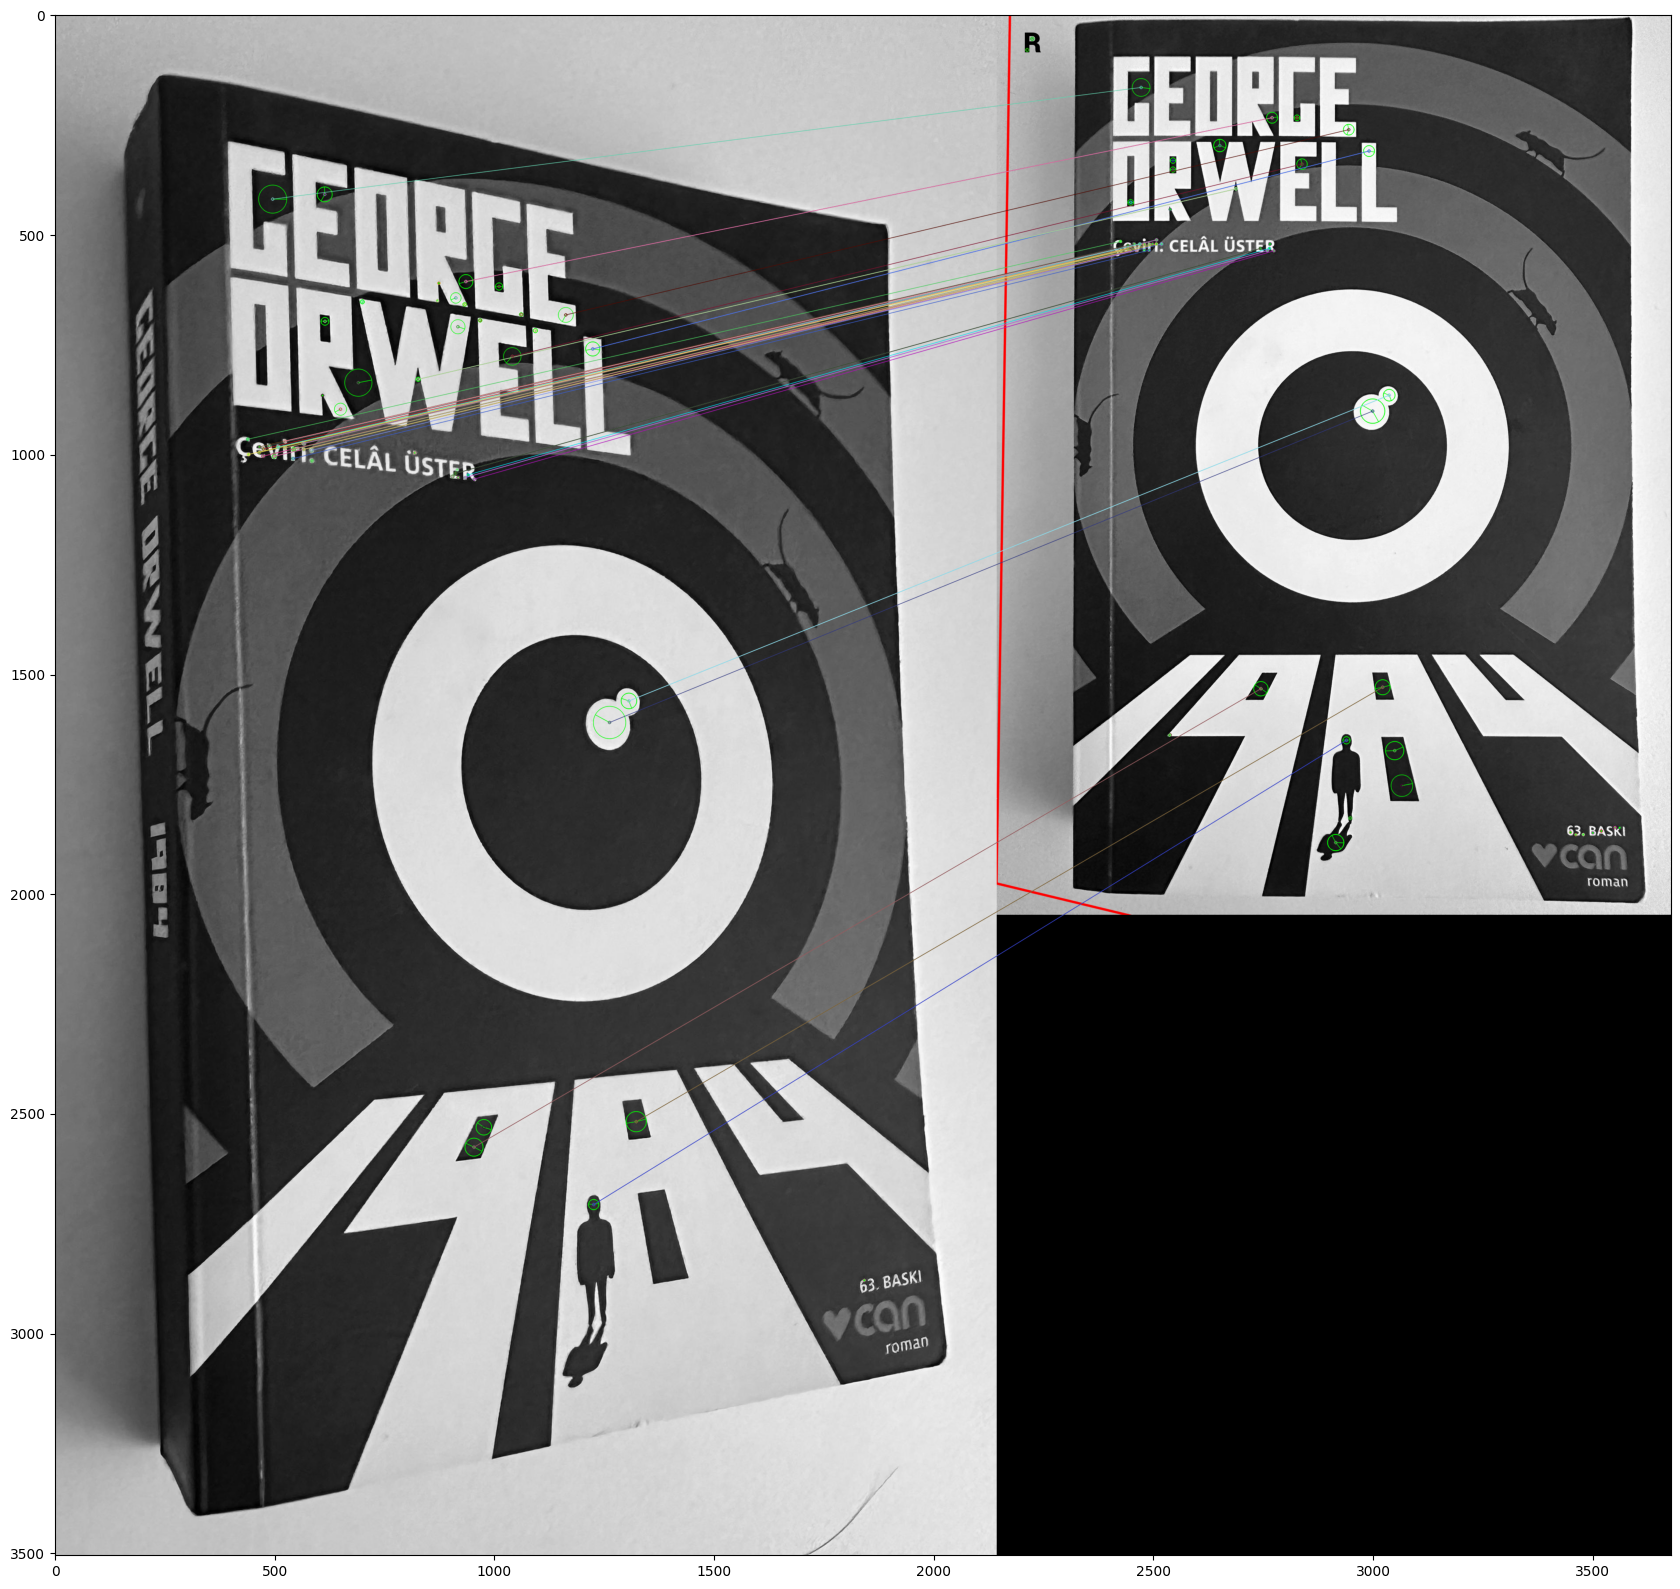

(<matplotlib.image.AxesImage at 0x7f79c57b9540>, None)

In [26]:
FLANN_INDEX_KDTREE = 1

index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

good = []
for m, n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

print("Number of good matches: ", len(good))

src_pts = []
dst_pts = []

for match in good:
    src_pts.append(alignKp[match.queryIdx].pt)
    dst_pts.append(referenceKp[match.trainIdx].pt)

src_pts = np.float32(src_pts).reshape(-1, 1, 2)
dst_pts = np.float32(dst_pts).reshape(-1, 1, 2)

matchedImage = cv2.drawMatches(imgAlign, alignKp, imgReference, referenceKp, good, None)
plt.figure(figsize=(30, 20))
plt.imshow(matchedImage, 'gray'), plt.show()

Homografi matrisi: 
[[ 5.62910125e-01 -9.32540203e-03  3.06101269e+01]
 [-1.38190012e-01  6.00581326e-01 -2.84988215e+01]
 [-1.38508853e-04  1.43308874e-05  1.00000000e+00]]


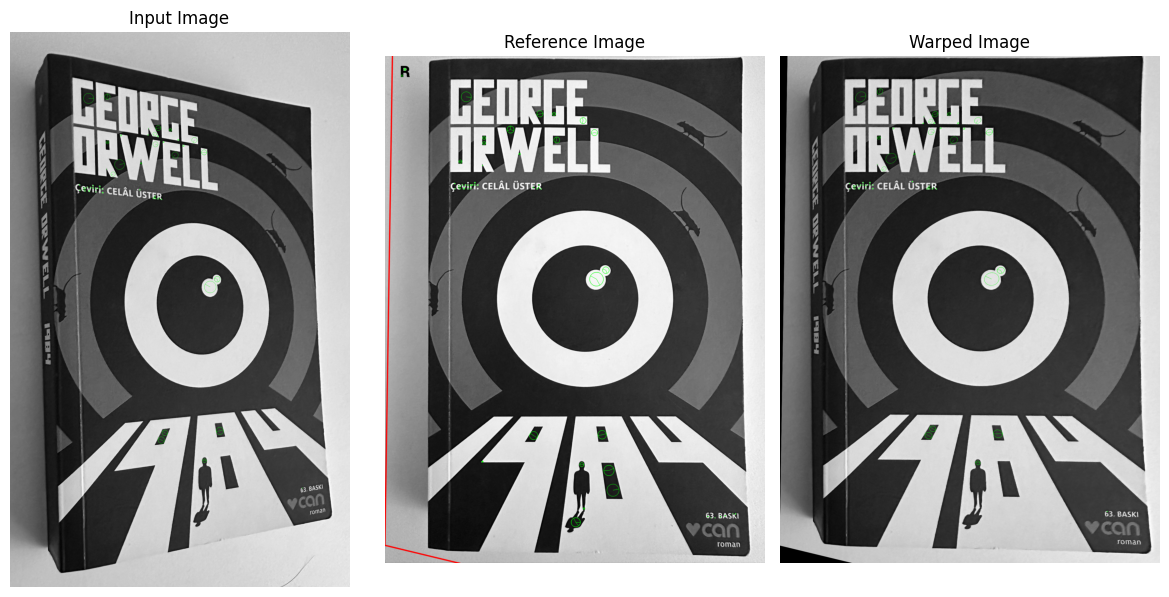

In [25]:
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

print(f"Homografi matrisi: \n{M}")

matchesMask = mask.ravel().tolist()

if M is not None:
    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)

    imgReference = cv2.polylines(imgReference, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

    im1_reg = cv2.warpPerspective(imgAlign, M, (imgReference.shape[1], imgReference.shape[0]))

    plt.figure(figsize=(12, 6))
    plt.subplot(131), plt.imshow(imgAlign, cmap='gray')
    plt.title('Input Image'), plt.axis('off')

    plt.subplot(132), plt.imshow(imgReference, cmap='gray')
    plt.title('Reference Image'), plt.axis('off')

    plt.subplot(133), plt.imshow(im1_reg, cmap='gray')
    plt.title('Warped Image'), plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Homografi bulunamadı.")